# Импорт библиотек

In [1]:
import os
import torch
import tarfile
import torchvision
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import copy

# Константы

In [2]:
TRAIN_DS_PATH = 'chest_xray_dataset/train'
VAL_DS_PATH = 'chest_xray_dataset/val'
TEST_DS_PATH = 'chest_xray_dataset/test'

BATCH_SIZE=64
SIZE=256

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [4]:
#!conda install pytorch torchvision torchaudio cudatoolkit=11.3 -y -c pytorch
#!conda install matplotlib -y
#!conda install tensorboard -y

# Вспомагательные функции

In [5]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
class Model(ImageClassificationBase):
    def __init__(self, arch):
        super().__init__()
        self.network = arch
        
    def forward(self, xb):
        return self.network(xb)

# Аугментация данных

In [6]:
transform_train = transforms.Compose([
    transforms.Resize([SIZE, SIZE]), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    
])

transform_test = transforms.Compose([
    transforms.Resize([SIZE, SIZE]), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    
])

transform_example = transforms.Compose([
    transforms.Resize([SIZE, SIZE]), 
    transforms.ToTensor(),
    
])

# Загрузка датасета из директорий

In [7]:
train_ds = ImageFolder(TRAIN_DS_PATH, transform=transform_train)
val_ds = ImageFolder(VAL_DS_PATH, transform=transform_test)
test_ds = ImageFolder(TEST_DS_PATH, transform=transform_test)
example_ds = ImageFolder(TRAIN_DS_PATH, transform=transform_example)

Количество изображения в датасете обучения, валидации и тестовом датасете:

In [8]:
len(train_ds),len(val_ds),len(test_ds)

(5218, 625, 26)

# Задание подгрузчиков датасета

In [9]:
#!lscpu

In [10]:
num_workers = 0

In [11]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, num_workers=num_workers, pin_memory=True)
test_dl = DataLoader(test_ds, BATCH_SIZE, num_workers=num_workers, pin_memory=True)

# Пример изображений 

images.shape: torch.Size([64, 3, 256, 256])


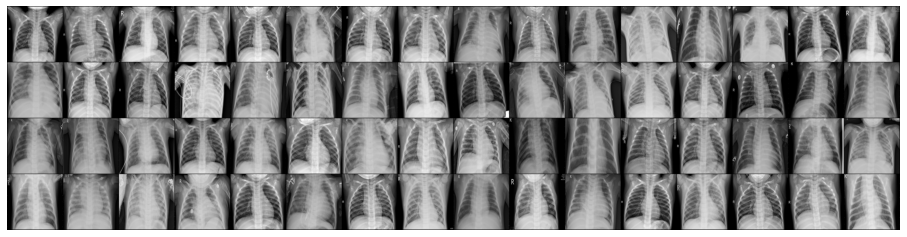

In [12]:
example_dl = DataLoader(example_ds, BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)


for images, _ in example_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break



In [13]:
import pathlib
root = pathlib.Path(TEST_DS_PATH)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes

['bac', 'norm', 'vir']

# Метрики

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Инициализация модели

In [15]:
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

# efficientnet.classifier.fc = nn.Linear(1280, 3)

# for p in efficientnet.parameters() : 
#     p.requires_grad = False
# for p in efficientnet.classifier.parameters() : 
#     p.requires_grad = True
    


In [16]:
modelvgg = torchvision.models.vgg19(pretrained = True)

# for p in modelvgg.parameters() : 
#     p.requires_grad = False
    
modelvgg.classifier = nn.Sequential(
  nn.Linear(in_features=25088, out_features=2048) ,
  nn.ReLU(),
  nn.Linear(in_features=2048, out_features=512) ,
  nn.ReLU(),
  nn.Dropout(p=0.6), 
    
  nn.Linear(in_features=512 , out_features=3),
  nn.LogSoftmax(dim=1)  
)

In [17]:
model = Model(modelvgg)

In [18]:
device = get_default_device()
device

device(type='cuda')

# Перенос Датасета и Модели с CPU на GPU

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

# Инициализация Tensorboard писателя

In [20]:
#writer = SummaryWriter('runs/pneum_experiment_1')

In [21]:
# get some random training images
#dataiter = iter(train_dl)
#images, labels = next(dataiter)

# create grid of images
#img_grid = torchvision.utils.make_grid(images)

# write to tensorboard
#writer.add_image('pneum_images', img_grid)

#writer.add_graph(model, images)
#writer.close()

# Обучение модели

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()   #eval() is called to tell model that now it is validation mode and so don't perform stuff like dropout,backpropagation etc..
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() #eval() is called to tell model that now it is training mode and so  perform stuff like dropout,backpropagation etc..
        train_losses = []
                
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        if epoch < 1:
                best_accuracy = result['val_acc']
                best_model = copy.deepcopy(model)
        else:
            if best_accuracy > result['val_acc']:
                pass
            else:
                best_accuracy = result['val_acc']
                best_model = copy.deepcopy(model)
        model.epoch_end(epoch, result)
        history.append(result)
    return history, best_model, best_accuracy

In [23]:
model = to_device(model, device)
evaluate(model, val_dl)

{'val_loss': 1.1064432859420776, 'val_acc': 0.2671875059604645}

In [24]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.0000001
history, best_model, best_accuracy = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.0931, val_loss: 1.0892, val_acc: 0.4482
Epoch [1], train_loss: 1.0683, val_loss: 1.0730, val_acc: 0.3844
Epoch [2], train_loss: 1.0406, val_loss: 1.0560, val_acc: 0.3859
Epoch [3], train_loss: 1.0079, val_loss: 1.0366, val_acc: 0.3922
Epoch [4], train_loss: 0.9735, val_loss: 1.0135, val_acc: 0.4156
Epoch [5], train_loss: 0.9302, val_loss: 0.9838, val_acc: 0.4594
Epoch [6], train_loss: 0.8847, val_loss: 0.9481, val_acc: 0.4969
Epoch [7], train_loss: 0.8351, val_loss: 0.9083, val_acc: 0.5312
Epoch [8], train_loss: 0.7815, val_loss: 0.8714, val_acc: 0.5469
Epoch [9], train_loss: 0.7319, val_loss: 0.8361, val_acc: 0.5655
Epoch [10], train_loss: 0.6885, val_loss: 0.8098, val_acc: 0.6042
Epoch [11], train_loss: 0.6547, val_loss: 0.7846, val_acc: 0.6310
Epoch [12], train_loss: 0.6289, val_loss: 0.7647, val_acc: 0.6543
Epoch [13], train_loss: 0.6075, val_loss: 0.7510, val_acc: 0.6698
Epoch [14], train_loss: 0.5841, val_loss: 0.7421, val_acc: 0.6864
Epoch [15], train_lo

In [31]:
model = best_model

In [32]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.000000001
history2 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.3896, val_loss: 0.7228, val_acc: 0.7732
Epoch [1], train_loss: 0.3915, val_loss: 0.7227, val_acc: 0.7732
Epoch [2], train_loss: 0.3965, val_loss: 0.7227, val_acc: 0.7732
Epoch [3], train_loss: 0.3918, val_loss: 0.7227, val_acc: 0.7732
Epoch [4], train_loss: 0.3955, val_loss: 0.7227, val_acc: 0.7732
Epoch [5], train_loss: 0.3885, val_loss: 0.7226, val_acc: 0.7732
Epoch [6], train_loss: 0.3853, val_loss: 0.7227, val_acc: 0.7732
Epoch [7], train_loss: 0.3875, val_loss: 0.7227, val_acc: 0.7732
Epoch [8], train_loss: 0.3935, val_loss: 0.7227, val_acc: 0.7732


KeyboardInterrupt: 

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.show();

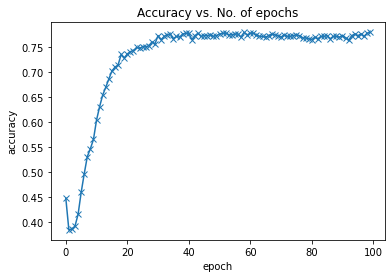

In [28]:
plot_accuracies(history)